### Presentation of DGL package through node classification
-----

This work is done by **FOFANA Cheick Tidiane** And **NIVET Isaac**.
In this presentation we are going to use the `Zachary karate club` dataset presented in the blog of `Tobias Skovgaard` given by `M Tommasi`.

In a nutshell, this dataset represesent members of a karate club and the edges their mutual relations. A conflict arose between the administrator and the instructor which resulted in the club splitting in two(labels).

This graph can be use to perform a classification task on the nodes using members features and graph structure.

In [1]:
import torch
import dgl.data
import numpy as np
import networkx as nx
import torch.nn as nn
from dgl.nn import GraphConv
import torch.nn.functional as F

Using backend: pytorch


In [2]:
dataset = dgl.data.KarateClubDataset()
graphe  = dataset[0] 

#### Dataset characteristics

/home/cheick/anaconda3/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.adjacency_matrix_scipy is deprecated. Please replace it with:

	DGLGraph.adjacency_matrix(transpose, scipy_fmt="csr").

  return warnings.warn(message, category=category, stacklevel=1)


(Graph information below)

Number of nodes      : 78
Number of edges      : 34
Number of categories : 2
Node features
[Important] Node 0 stands for the instructor, node 33 for the club administrator / president.
Node labels : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


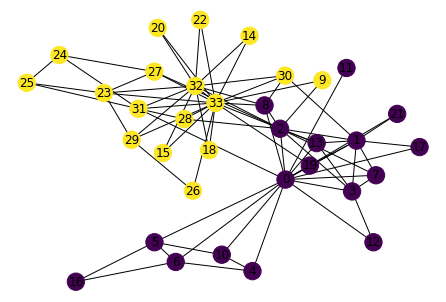

In [3]:
G_networkx_version = nx.Graph(dataset._graph.adjacency_matrix_scipy().todense())
print("(Graph information below)")
print()
print("Number of nodes      :", G_networkx_version.number_of_edges())
print("Number of edges      :", G_networkx_version.number_of_nodes())
print("Number of categories :", dataset.num_classes)
print('Node features')
print("[Important] Node 0 stands for the instructor, node 33 for the club administrator / president.")
print("Node labels :", graphe.ndata['label'])
nx.draw(G_networkx_version, with_labels = True, node_color=graphe.ndata['label'])

**Importants :** This dataset has no feature for nodes. We are going to concatenate to representation(like in the given blog). The first one is by using simply the Identity matrix as features, where each node(member) is represented by a one hot encoding of his relative position in the graph. We will improve representation 1 by adding two features that are not specific to any node or area of the network, but measures the connectedness to the administrator and instructor. To this end, we compute the shortest path distance from each node in the network to both the administrator and instructor and concatenate these two features to the previous representation.

In [4]:
def getTheshortestPath(graph):
    results_intrusctor    = []
    results_administrator = []
    for node in range(graph.number_of_nodes()):
        results_intrusctor += [ len(nx.shortest_path(graph, source=0, target=node)) - 1 ]
        results_administrator += [ len(nx.shortest_path(graph, source=33, target=node)) - 1 ]
    
    results_intrusctor    = np.array(results_intrusctor)
    results_administrator = np.array(results_administrator)

    return np.vstack([results_intrusctor, results_administrator])


In [5]:
identity_representation = np.identity(G_networkx_version.number_of_nodes())
shortest_path_from_intructor_and_administrator = getTheshortestPath(G_networkx_version).T
shortest_path_from_intructor_and_administrator.shape

(34, 2)

In [6]:
features = np.hstack([identity_representation, shortest_path_from_intructor_and_administrator])
assert features.shape[1] == G_networkx_version.number_of_nodes() + 2

In [7]:
features.shape

(34, 36)

 * Now we can create the model class called **GCN**

In [8]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes=2):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

* Now let make the train function

In [9]:
def train(graph, model, graphe_features, epochs=100, show_every=10, p_labelled=0.3):
    assert 0 < p_labelled < 1
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    labels = torch.LongTensor(graph.ndata['label'])
    train_mask = [True] + list(np.random.choice([True, False], size=32, p=[p_labelled, 1-p_labelled])) + [True]
    
    for epoch in range(epochs):
        logits = model(graph, torch.Tensor(graphe_features))

        pred = logits.argmax(1)
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        test_acc = (pred == labels).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % show_every == 0:
            print('In epoch {}, loss: {:.3f}, train acc: {:.3f}, test acc: {:.3f}'.format(
                epoch, loss, train_acc, test_acc))

In [10]:
model = GCN(features.shape[1], 16)
train(graphe, model, features)

<ipython-input-9-ff5d89ddd7b6>:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])
<ipython-input-9-ff5d89ddd7b6>:14: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
/home/cheick/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In epoch 0, loss: 0.729, train acc: 0.000, test acc: 0.059
In epoch 10, loss: 0.483, train acc: 1.000, test acc: 0.971
In epoch 20, loss: 0.262, train acc: 1.000, test acc: 0.971
In epoch 30, loss: 0.115, train acc: 1.000, test acc: 0.971
In epoch 40, loss: 0.051, train acc: 1.000, test acc: 0.971
In epoch 50, loss: 0.025, train acc: 1.000, test acc: 0.971
In epoch 60, loss: 0.015, train acc: 1.000, test acc: 0.971
In epoch 70, loss: 0.010, train acc: 1.000, test acc: 0.971
In epoch 80, loss: 0.008, train acc: 1.000, test acc: 0.971
In epoch 90, loss: 0.006, train acc: 1.000, test acc: 0.971


**Interpretation :** We can see here, that the model converge with 270 epochs, using Adam optimizer it converge way faster. Results are pretty good. and we have a test accuray of `0.97` in less than 30 epochs. We may consider this cheating a little bit, since we inject global information about the location of each node in the graph; information which should (ideally) be captured by the graph convolutional layers in the features component.   